# Exercise 2b
## Loïc Rosset, Nanae Aubry, Kilian Ruchti, Lionel Ieri
## Import libraries

In [1]:
# Import module
import pandas as pd
import math
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

from copy import deepcopy

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

%matplotlib inline
import matplotlib.pyplot as plt

# load data

In [2]:
#path to dataset
mnist_train = "./../dataset/csv/mnist_train.csv"
mnist_test = "./../dataset/csv/mnist_test.csv"

In [3]:
def read_data(filename):
    df = pd.read_csv(filename, header=None)
    #data into numpy array
    data = df.iloc[:, 1:].values.reshape(-1, 1, 28, 28) /255.0
    labels = df.iloc[:, 0].values
    return data, labels

In [4]:
# Load the training and the test set
training_data, training_labels = read_data(mnist_train)
test_data, test_labels = read_data(mnist_test)

# Create validation data from training data (15%)
size_data = len(training_data)
limit = math.floor(3*size_data/20)

val_data = training_data[:limit]
train_data = training_data[limit:]

val_labels = training_labels[:limit]
train_labels = training_labels[limit:]

In [5]:
# Create MnistDataset for Pytorch in tensor format
class MnistDataset(Dataset):
    def __init__(self, data, label):
        tensor_data = torch.from_numpy(data.astype(np.float32))
        self.data = tensor_data
        self.label = torch.from_numpy(label)
        self.n_samples = data.shape[0]
        
    def __getitem__(self, index):
        return self.data[index], self.label[index]
    
    def __len__(self):
        return self.n_samples

In [6]:
train_dataset = MnistDataset(train_data, train_labels)
val_dataset = MnistDataset(val_data, val_labels)
test_dataset = MnistDataset(test_data, test_labels)

# Create data loader
params = {'batch_size': 32, 'shuffle': True}

train_loader = torch.utils.data.DataLoader(train_dataset, **params)
val_loader = torch.utils.data.DataLoader(val_dataset, **params)
test_loader = torch.utils.data.DataLoader(test_dataset, **params)

# Study dataset

In [7]:

def plot_graph(nb_epochs, train, val, step):
    plt.figure()
    plt.plot(np.arange(nb_epochs), train)
    plt.plot(np.arange(nb_epochs), val)
    plt.legend(['training', 'validation'])
    plt.xlabel('epoch')
    plt.ylabel(f'{step} value')
    plt.title(f'Train/val {step}');
        
    plt.show()

In [8]:
class Training():
    
    def __init__(self, nb_epochs=20, device=torch.device('cpu')):
        self.nb_epochs = nb_epochs
        self.device = device
    
    def train(self, model, train_loader, optimizer, loss_func):
        model.train()
        
        losses = []
        correct_train_pred = 0
        
        for data, labels in train_loader:
            data = data.to(self.device)
            labels = labels.to(self.device)
                        
            # Predict the classes of the model
            output = model(data)
            
            optimizer.zero_grad()
            
            # Compute the loss
            loss = loss_func(output, labels)
            
            # Perform backprop
            loss.backward()
            optimizer.step()
            
            # Save current loss
            losses.append(loss.item())
            
            # Save the number of correct classified items
            predicted_labels = output.argmax(dim=1)
            nb_correct = (predicted_labels == labels).sum().item()
            correct_train_pred += nb_correct
    
        train_accuracy = 100. * (correct_train_pred / len(train_loader.dataset))
        
        return np.mean(np.array(losses)), train_accuracy
    
    def validation(self, model, val_loader, loss_func):
        model.eval()
        
        losses = []
        correct_val_predictions = 0
        
        with torch.no_grad():
            for data, labels in val_loader:
                data = data.to(self.device)
                labels = labels.to(self.device)
                
                output = model(data)
                
                loss = loss_func(output, labels)
                
                # Save current loss
                losses.append(loss.item())
    
                # Save the number of correct classified items
                predicted_labels = output.argmax(dim=1)
                n_correct = (predicted_labels == labels).sum().item()
                correct_val_predictions += n_correct
                
        val_accuracy = 100. * (correct_val_predictions / len(val_loader.dataset))
                
        return np.mean(np.array(losses)), val_accuracy

    def _print_info(self, train_loss, val_loss, train_acc, val_acc):
        print(f'Train_loss: {train_loss:.3f} |\
                Val_loss: {val_loss:.3f} |\
                Train_acc: {train_acc:.3f} |\
                Val_acc: {val_acc:.3f}\n')

    def fit(self, model, train_loader, val_loader, optimizer, loss_func):
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        for epoch in range(self.nb_epochs):
            train_loss, train_acc = self.train(model, train_loader, optimizer, loss_func)
            val_loss, val_acc = self.validation(model, val_loader, loss_func)

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

        self._print_info(train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1])

        return train_losses, val_losses, train_accuracies, val_accuracies

In [9]:
class MLP(nn.Module):
    
    def __init__(self, nhl):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, nhl),
            nn.ReLU(),
            nn.Linear(nhl, 10)
        )
        
    def forward(self, x):
        # Flatten the images
        x = x.view(x.size(0), -1)
        # Create the layer
        x = self.layers(x)
        return x

number neurons: 10, learning rate: 0.001
Train_loss: 0.245 |                Val_loss: 0.268 |                Train_acc: 93.090 |                Val_acc: 92.522

number neurons: 10, learning rate: 0.01
Train_loss: 0.242 |                Val_loss: 0.280 |                Train_acc: 92.918 |                Val_acc: 92.822

number neurons: 10, learning rate: 0.1
Train_loss: 1.678 |                Val_loss: 1.741 |                Train_acc: 33.400 |                Val_acc: 29.844

number neurons: 50, learning rate: 0.001
Train_loss: 0.061 |                Val_loss: 0.108 |                Train_acc: 98.114 |                Val_acc: 96.844

number neurons: 50, learning rate: 0.01
Train_loss: 0.110 |                Val_loss: 0.247 |                Train_acc: 97.073 |                Val_acc: 95.011

number neurons: 50, learning rate: 0.1
Train_loss: 1.346 |                Val_loss: 1.709 |                Train_acc: 51.590 |                Val_acc: 53.333

number neurons: 100, learning rate: 0.00

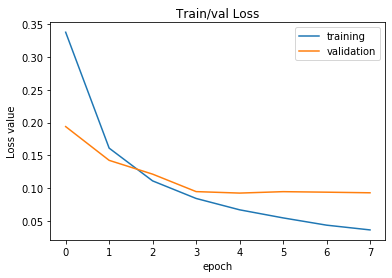

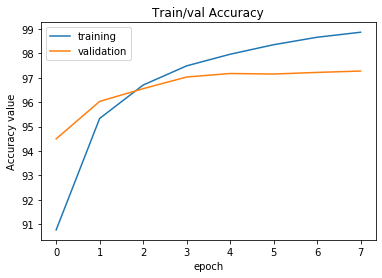

In [10]:
# Initial data
nhl_set = [10, 50, 100]
l_rate_set = [0.001, 0.01, 0.1]
nb_epochs = 8
loss_function = nn.CrossEntropyLoss()

trainer = Training(nb_epochs)

# best parameters: (validation acc, number neurons, learning rate)
best_parameters = (float("-INF"), None, None, None)

# keep a copy of the best trained network
best_model = None

for nhl in nhl_set:
        for l_rate in l_rate_set:
            mlp = MLP(nhl)
            optimizer = torch.optim.Adam(mlp.parameters(), lr=l_rate)

            # The training take place here :
            print(f'number neurons: {nhl}, learning rate: {l_rate}')
            stats_training = trainer.fit(mlp, train_loader, val_loader, optimizer, loss_function)

            if stats_training[3][-1] > best_parameters[0]:
                best_parameters = (stats_training[3][-1], nhl, l_rate, stats_training)
                best_model = deepcopy(mlp)

best_acc, best_nhl, best_l_rate, best_stats = best_parameters
train_losses, val_losses, train_accuracies, val_accuracies = best_stats

print(f'\n\nBest parameters: {best_nhl} number of neurons in hidden layer, {best_l_rate} learning_rate and validation accuracies: {best_acc:.2f}%')

plot_graph(nb_epochs, train_losses, val_losses, "Loss")
plot_graph(nb_epochs, train_accuracies, val_accuracies, "Accuracy")

In [11]:
mlp_loss_test, mlp_acc_test = trainer.validation(best_model, test_loader, loss_function)
print(f'Accuracy on the test dataset {mlp_acc_test:.2f}%')

Accuracy on the test dataset 97.45%
